In [2]:
import numpy as np
np.random.seed(42)
import random
random.seed(42)
from collections import Counter
import operator
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds as svd

from sklearn.decomposition import NMF

from sklearn.datasets import fetch_20newsgroups
from scipy.sparse.linalg import norm
from scipy.sparse import csr_matrix as matrix

# question 4
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import math

In [4]:
#Question 1
#Histogram containing the total number of training documents per category.

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

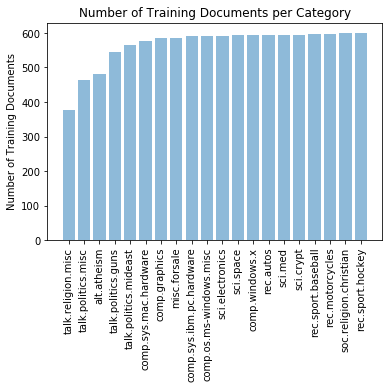

In [43]:
targets = newsgroups_train.target
target_names = newsgroups_train.target_names
target_frequency = Counter(targets)
target_frequency = sorted(target_frequency.items(), key=operator.itemgetter(1))
labels = []
freqs = []

for e in target_frequency:
    labels.append(target_names[e[0]])
    freqs.append(e[1])
# print(X)
# print(Y)

plt.bar(labels, freqs, align='center', alpha=0.5)
plt.xticks(rotation=90)
plt.ylabel("Number of Training Documents")
plt.title("Number of Training Documents per Category")

plt.show()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(newsgroups_train.data[:2])
# print(vectorizer.get_feature_names(), X)

In [ ]:
import re
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

In [7]:
lemmatizer = WordNetLemmatizer()
stop_words = set(nltk.corpus.stopwords.words('english'))

def no_num_tokenizer(document):
    unlemmatized_words = [word for word in re.split('[^a-zA-Z]+', document) if len(word)>2]
    words = [lemmatizer.lemmatize(word) for word in unlemmatized_words if word not in stop_words]
    return words

This is a really bad lemmatizer. It does nothing except for changing plurals to their singular form

In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem import WordNetLemmatizer

vectorizer = CountVectorizer(stop_words=None, tokenizer=no_num_tokenizer, min_df=3)
tf_train = vectorizer.fit_transform(newsgroups_train.data)

tf_test = vectorizer.transform(newsgroups_test.data)

In [9]:
df_train = (tf_train>0).sum(axis=0).flatten()
idf_train = np.log(tf_train.shape[0]/df_train)+1

# df_test = (tf_test>0).sum(axis=0).flatten()
# idf_test = np.log(tf_train.shape[0]/df_train)+1
# https://stats.stackexchange.com/questions/154660/tfidfvectorizer-should-it-be-used-on-train-only-or-traintest

df_test = (tf_test>0).sum(axis=0).flatten()
# idf_test = np.log(tf_train.shape[0]/df_test)+1

In [10]:
tf_idf_train = tf_train.copy().astype(float)

for i in range(tf_train.shape[1]):
    tf_idf_train[:,i] = tf_train[:,i] * idf_train[0,i]

print(tf_idf_train.shape)

(11314, 29930)


In [11]:
tf_idf_test = tf_test.copy().astype(float)

for i in range(tf_test.shape[1]):
    tf_idf_test[:,i] = tf_test[:,i] * idf_train[0,i]

print(tf_idf_test.shape)

(7532, 29930)


In [12]:
# np.random.shuffle(tf_idf_train)

In [13]:
X_train = tf_idf_train
X_test = tf_idf_test

k = 50

Uk, s, VT = svd(X_train,k=k) #X is TF-IDF matrix from problem 2
# s[::-1].sort() # use this method or the one below

# Vk = VT.transpose()


X_train_lsa = Uk.dot(np.diag(s).dot(VT))

In [14]:
#NMF
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
model = NMF(n_components=k, init='random', random_state=0)
W = model.fit_transform(X_train)
H = model.components_

X_train_nmf = np.matmul(W, H)

In [15]:
# n,m = X_train.shape

# fnorm_lsa = 0.0
# fnorm_nmf = 0.0

# for i in range(n):
    
#     print(i)
#     for j in range(m):
#         fnorm_lsa += (X_train[i,j]-X_train_lsa[i,j])**2
#         fnorm_nmf += (X_train[i,j]-X_train_nmf[i,j])**2

norm((matrix(X_train_lsa)-matrix(X_train)), ord='fro')

# X_train_nmf.shape

MemoryError: Unable to allocate 5.05 GiB for an array with shape (338628020, 2) and data type int64

In [20]:
X_train_reduced = X_train.dot(VT.T)
X_test_reduced = X_test.dot(VT.T)

In [23]:
#Problem 4 SVM

Train_X = X_train_reduced
Train_Y = newsgroups_train.target
Test_X = X_test_reduced
Test_Y = newsgroups_test.target

In [132]:
soft_svm = SVC(gamma = 0.0001)
soft_svm.fit(Train_X, Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [143]:
soft_svm.score(Train_X, Train_Y)

0.5167933533675093

In [138]:
Y_predict_soft = soft_svm.predict(Test_X)
soft_accuracy = soft_svm.score(Test_X, Test_Y)
soft_precision, soft_recall, soft_f1 = precision_score(Test_Y, Y_predict_soft, average='micro'), recall_score(Test_Y, Y_predict_soft, average='micro'), f1_score(Test_Y, Y_predict_soft, average='micro')
# soft_fpr, soft_tpr, soft_thresholds = roc_curve(Test_Y, Y_predict_soft)
print("The soft SVM accuracy is:", soft_accuracy)
print("Soft SVM f1 score:", soft_f1)

The soft SVM accuracy is: 0.459506107275624
Soft SVM f1 score: 0.459506107275624


In [141]:
hard_svm = SVC(gamma = 1000)
hard_svm.fit(Train_X, Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1000, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [142]:
Y_predict_hard = hard_svm.predict(Test_X)
hard_accuracy = hard_svm.score(Test_X, Test_Y)
hard_precision, hard_recall, hard_f1 = precision_score(Test_Y, Y_predict_hard, average='micro'), recall_score(Test_Y, Y_predict_hard, average='micro'), f1_score(Test_Y, Y_predict_hard, average='micro')
# hard_fpr, hard_tpr, hard_thresholds = metrics.roc_curve(Test_Y, Y_predict_hard)

print("The hard SVM accuracy is:", hard_accuracy)
print("Hard SVM f1 score:", hard_f1)

The hard SVM accuracy is: 0.054168879447689854
Hard SVM f1 score: 0.054168879447689854


In [ ]:
best_score = 0.0
best_gamma = None
best_classifier = None

kf = KFold(n_splits=5)
for i in range(-3, 4, 1):
    scores = []
    gamma = pow(10, i)
    for train_index, test_index in kf.split(Train_X):
        X_train, X_test = Train_X[train_index], Train_X[test_index]
        y_train, y_test = Train_Y[train_index], Train_Y[test_index]
        clf = SVC(gamma = gamma)
        clf.fit(X_train, y_train)
        scores.append(clf.score(X_test, y_test))
    average_score = np.mean(scores)
    print(gamma, average_score)
    if average_score > best_score:
        best_score = average_score
        best_gamma = gamma
        best_classifier = clf

In [147]:
print("The best gamma hyper parameter is: " + str(best_gamma))
print("The best mean score is: " + str(best_score))

The best gamma hyper parameter is: 0.01


NameError: name 'score' is not defined

In [ ]:
best_predict = best_classifier.predict(Test_X)
best_accuracy = best_classifier.score(Test_X, Test_Y)
precision, recall, f1 = precision_score(Test_Y, best_predict, average='micro'), recall_score(Test_Y, best_predict, average='micro'), f1_score(Test_Y, best_predict, average='micro')
fpr, tpr, thresholds = metrics.roc_curve(Test_Y, best_predict)

In [37]:
# Question 5
from sklearn.linear_model import LogisticRegression

logistic_model = LogisticRegression(C=1.0e15, max_iter=1000)
logistic_model.fit(Train_X, Train_Y)

c:\program files\python37\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1000000000000000.0, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:
print("Logistic regression test accuracy:", logistic_model.score(Test_X, Test_Y))
print("Logistic regression train accuracy:", logistic_model.score(Train_X, Train_Y))

Predicted_Y = logistic_model.predict(Test_X)
precision = precision_score(Test_Y, Predicted_Y, average='micro')
recall = recall_score(Test_Y, Predicted_Y, average='micro')
f1 = f1_score(Test_Y, Predicted_Y, average='micro')

print("Overall precision:", precision)
print("Overall recall:", recall)
print("Overall f1 score:", f1)
print()

for label in range(20):

    precision = precision_score(Test_Y == label, Predicted_Y == label)
    recall = recall_score(Test_Y == label, Predicted_Y == label)
    f1 = f1_score(Test_Y == label, Predicted_Y == label)

    print("Precision for label '{}':".format(target_names[label]), precision)
    print("Recall for label '{}':".format(target_names[label]), recall)
    print("f1 score for label '{}':".format(target_names[label]), f1)

Logistic regression test accuracy: 0.6270578863515667
Logistic regression train accuracy: 0.6914442283896058
Overall precision: 0.6270578863515667
Overall recall: 0.6270578863515667
Overall f1 score: 0.6270578863515667

Precision for label 'alt.atheism': 0.5252525252525253
Recall for label 'alt.atheism': 0.4890282131661442
f1 score for label 'alt.atheism': 0.5064935064935064
Precision for label 'comp.graphics': 0.6046511627906976
Recall for label 'comp.graphics': 0.6683804627249358
f1 score for label 'comp.graphics': 0.6349206349206348
Precision for label 'comp.os.ms-windows.misc': 0.597667638483965
Recall for label 'comp.os.ms-windows.misc': 0.5203045685279187
f1 score for label 'comp.os.ms-windows.misc': 0.5563093622795116
Precision for label 'comp.sys.ibm.pc.hardware': 0.5094339622641509
Recall for label 'comp.sys.ibm.pc.hardware': 0.413265306122449
f1 score for label 'comp.sys.ibm.pc.hardware': 0.4563380281690141
Precision for label 'comp.sys.mac.hardware': 0.516042780748663
Recall

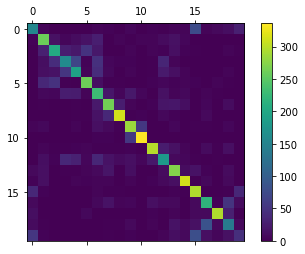

[[156   4   0   0   1   0   4   3   0   6   0   3   2   4   5  77   4   8
   12  30]
 [  3 260  15   6  11  17  28   0   4   2   5   4  10  15   6   1   1   0
    1   0]
 [  1  30 205  28  22  49  21   1   1   4   0   4   3  14   3   2   0   0
    4   2]
 [  0  13  43 162  70   3  46   6   3   3   0   2  35   5   1   0   0   0
    0   0]
 [  0  14  17  52 193   5  42   7   1   4   1   2  24  14   5   0   0   0
    4   0]
 [  0  38  48   2   1 262  12   2   2   1   0   3   6   3   5   3   1   4
    2   0]
 [  0   7   6  27  26   4 230  20   6  22   6   1  15   5   7   0   4   2
    1   1]
 [  0   2   1   0   2   1  23 264  27   5   0   3  19  20  12   0   6   0
   11   0]
 [  1   1   0   0   2   2  16  37 313   2   3   0   7   3   1   1   8   0
    1   0]
 [  4   7   0   0   4   1  14   9   2 285  54   0   0   6   0   2   2   1
    6   0]
 [  0   0   0   0   0   1   3   3   0  54 336   0   0   0   0   1   0   0
    1   0]
 [  0   4   2   2   3   5   2   2   2   3   0 299  25  15   4   1

In [49]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(Test_Y, Predicted_Y)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_matrix)
fig.colorbar(cax)
plt.show()

print(conf_matrix)

In [59]:
import warnings
warnings.filterwarnings('ignore')

kf = KFold(n_splits=5)

score_for_C_l2 = {}

for C in np.geomspace(1e-3,1e3, num=7):
    
    kf_scores = []
    
    for train_ix, test_ix in kf.split(Train_X):
        logistic_model = LogisticRegression(C=C, max_iter=100)
        logistic_model.fit(Train_X[train_ix], Train_Y[train_ix])
        kf_scores.append(logistic_model.score(Train_X[test_ix], Train_Y[test_ix]))
        
    score_for_C_l2[C] = np.mean(kf_scores)
    print("Score for C=",C,":",score_for_C_l2[C])

0.001
0.01
0.1
1.0
10.0
100.0
1000.0


In [63]:
best_C_l2 = max(score_for_C_l2.keys(),key=score_for_C_l2.get)
print("Best value of lambda for L2:", 1/best_C_l2)

best_logistic_model_l2 = LogisticRegression(C=best_C_l2, max_iter=100)
best_logistic_model_l2.fit(Train_X, Train_Y)
print("Test accuracy for best value of lambda for L2:", best_logistic_model_l2.score(Test_X, Test_Y))

Best value of C: 10.0
Accuracy for best value of C: 0.6620112969450893


{0.001: 0.6389418754710479,
 0.01: 0.6633368145459205,
 0.1: 0.6634253100174139,
 1.0: 0.6615692493669546,
 10.0: 0.6620112969450893,
 100.0: 0.6622765880053276,
 1000.0: 0.6623648099808827}

In [66]:
kf = KFold(n_splits=5)

score_for_C_l1 = {}

for C in np.geomspace(1e-3,1e3, num=7):
    
    kf_scores = []
    
    for train_ix, test_ix in kf.split(Train_X):
        logistic_model = LogisticRegression(C=C, max_iter=100, penalty='l1', solver='saga')
        logistic_model.fit(Train_X[train_ix], Train_Y[train_ix])
        kf_scores.append(logistic_model.score(Train_X[test_ix], Train_Y[test_ix]))
    
    score_for_C_l1[C] = np.mean(kf_scores)
    print("Score for C=",C,":",score_for_C_l1[C])

Score for C= 0.001 (L2): 0.374492362235212
Score for C= 0.01 (L2): 0.4886865279417125
Score for C= 0.1 (L2): 0.4992043612443752
Score for C= 1.0 (L2): 0.4991158657728819
Score for C= 10.0 (L2): 0.4993810396205752
Score for C= 100.0 (L2): 0.49938111776227184
Score for C= 1000.0 (L2): 0.49929262229077853


In [ ]:
best_C_l1 = max(score_for_C_l1.keys(),key=score_for_C_l1.get)
print("Best value of lambda for l1:", 1/best_C_l1)

best_logistic_model_l1 = LogisticRegression(C=best_C_l1, max_iter=100, penalty='l1', solver='saga')
best_logistic_model_l1.fit(Train_X, Train_Y)
print("Test accuracy for best value of lambda for l1:", best_logistic_model_l1.score(Test_X, Test_Y))

Best value of lambda for l1: 0.01
